# GWAS Tutorial: with covariates

This tutorial builds on [the simple GWAS tutorial](GWAS.html) and [the PCA tutorial](PCA.html). Here we show how to perform a GWAS with covariates. In this case, we use the first 10 principal components as the covariates, but covariates can be anything relating to the phenotype $Y$. Again, this is simple linear regression. We're using [Genotype Representation Graphs](https://grgl.readthedocs.io/en/stable/concepts.html#grg) to represent our genotype matrix. If you're not sure how to get a GRG, start with [the simple GWAS tutorial](GWAS.html) instead, since we are re-using the `gwas.example.grg` from that tutorial.

**What you'll need:**

* Files: `gwas.example.grg`
* Python dependencies "grapp", "seaborn": `pip install grapp igdtools seaborn`

## Simulate Phenotype

Like the simple GWAS tutorial, we are mostly using the default settings for phenotype simulation, which just draws effect sizes for causal SNPs from a standard normal distribution ~$N(0, 1)$. However, we are going to add a slight complication: we are going to assume that there is a binary attribute of individuals that affects the phenotype, but is not genetic (or at least, is more environmental than genetic). We can do this by using the [grg_pheno_sim Python APIs](https://grg-pheno-sim.readthedocs.io/en/latest/grg_pheno_sim.html) and specifying a covariate as input to the simulation.

In [1]:
import numpy
import pygrgl

numpy.random.seed(42)

# Load the GRG dataset
grg = pygrgl.load_immutable_grg("gwas.example.grg")

# Generate our random (binary) environment attribute that affects Y
env_attribute = ((numpy.random.uniform(size=(grg.num_individuals, 1)) > 0.5) * 1).astype(numpy.float64)

In [2]:
from grg_pheno_sim.phenotype import add_covariates, convert_to_phen
import pandas

# Now simulate our phenotype, taking into account that our environmental attribute affects it
heritability = 0.33   # h^2

covar = env_attribute
covar_effect = numpy.array([1000.0]) # Effect that the covariate has on the final phenotype value
# add_covariates() takes all the same keyword arguments as sim_phenotypes()
phenotypes = add_covariates(grg, covar, covar_effect, heritability=heritability)
# Write the dataframe to a file format that can be used for GWAS
convert_to_phen(phenotypes, "covar.example.grg.phen", include_header=True)

The initial effect sizes are 
       mutation_id  effect_size  causal_mutation_id
0                0    -1.657757                   0
1                1    -0.537562                   0
2                2     1.146189                   0
3                3    -0.697705                   0
4                4    -0.157002                   0
...            ...          ...                 ...
10888        10888    -0.217740                   0
10889        10889     0.936594                   0
10890        10890     0.976964                   0
10891        10891     0.274724                   0
10892        10892     0.711005                   0

[10893 rows x 3 columns]
The genetic values of the individuals are 
     individual_id  genetic_value  causal_mutation_id
0                0     -62.758200                   0
1                1       8.271010                   0
2                2     -93.726026                   0
3                3     -58.657459                   0
4      

In [3]:
phenotypes

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype,covariate_value
0,0,0,-62.758200,-0.602121,-63.360321,0.0
1,0,1,8.271010,36.560018,1044.831028,1000.0
2,0,2,-93.726026,99.231737,1005.505711,1000.0
3,0,3,-58.657459,-53.501572,887.840969,1000.0
4,0,4,-47.272752,-34.094395,-81.367147,0.0
...,...,...,...,...,...,...
195,0,195,-22.379358,7.807964,-14.571394,0.0
196,0,196,34.579149,-124.553807,910.025342,1000.0
197,0,197,-40.854451,-31.724121,927.421427,1000.0
198,0,198,-21.653168,-76.349435,901.997397,1000.0


## Get the top 2 principal components

The top 10 principal components (those associated with the 10 largest eigenvalues) of the genotype matrix $X$ are often used to correct for population stratification when performing GWAS. These PCs are the dimensions of most variance across the dataset, which is expected to reflect genetic differences primarily due to individuals being from different ancestral populations (those are the "biggest" genetic differences). Since this dataset is so small, we just use 2 PCs here, which we compute from our GRG.

In [4]:
%%bash
grapp pca -d 2 gwas.example.grg -o gwas.covar.pcs.tsv

Wrote PCs to gwas.covar.pcs.tsv


In [5]:
import pandas
# Load our PCs and display the dataframe
pca_df = pandas.read_csv("gwas.covar.pcs.tsv", delimiter="\t")
pca_df

,PC1,PC2
0,-5.286404,24.681425
1,14.533814,14.576620
2,1.614064,-8.493021
3,12.886069,-1.155761
4,-2.087363,-8.376788
...,...,...
195,-4.182446,-5.131653
196,0.434597,-0.313486
197,27.490636,-8.227627
198,15.201642,-8.993395


We want to combine the PCs and our attribute into a single dataframe, which we will use as the covariates input to our GWAS.

In [6]:
attr_df = pandas.DataFrame({"EnvAttr": env_attribute.T[0]})
covar_df = pandas.concat([pca_df, attr_df], axis=1)
covar_df.to_csv("covar.example.covar.tsv", sep="\t", index=False)
covar_df

,PC1,PC2,EnvAttr
0,-5.286404,24.681425,0.0
1,14.533814,14.576620,1.0
2,1.614064,-8.493021,1.0
3,12.886069,-1.155761,1.0
4,-2.087363,-8.376788,0.0
...,...,...,...
195,-4.182446,-5.131653,0.0
196,0.434597,-0.313486,1.0
197,27.490636,-8.227627,1.0
198,15.201642,-8.993395,1.0


## Perform association with covariates

We want a GWAS that "ignores the effects" of the covariates, which are 10 PCs + one individual attribute in our case.

### GWAS via command line

First we'll run the shell commands that perform a GWAS.

In [7]:
%%bash

# Using our phenotype file, emit a tab-separated (tsv) pandas dataframe containing the results of our GWAS with covariates
grapp assoc -c covar.example.covar.tsv -p covar.example.grg.phen -o covar.example.gwascov.tsv gwas.example.grg

# Same thing, but WITHOUT covariates, just for comparison
grapp assoc -p covar.example.grg.phen -o covar.example.gwas.tsv gwas.example.grg

Wrote results to covar.example.gwascov.tsv
Wrote results to covar.example.gwas.tsv


Now we can examine both results by loading the dataframes into pandas.

In [8]:
import pandas

gwascov_df = pandas.read_csv("covar.example.gwascov.tsv", delimiter="\t")
gwas_df = pandas.read_csv("covar.example.gwas.tsv", delimiter="\t")
gwascov_df

,POS,ALT,COUNT,BETA,SE,T,P
0,55829,G,4,-51.048086,127.006567,-0.401933,0.688172
1,56812,T,3,-13.716917,152.570359,-0.089906,0.928454
2,57349,G,1,-28.959683,467.645128,-0.061927,0.950684
3,58785,T,10,-35.693720,38.173918,-0.935029,0.350924
4,59367,A,2,17.971173,238.352202,0.075398,0.939975
...,...,...,...,...,...,...,...
10888,9997601,G,3,9.707284,152.495658,0.063656,0.949309
10889,9998038,A,21,10.507445,21.127264,0.497341,0.619506
10890,9998412,G,42,5.477115,28.741514,0.190565,0.849064
10891,9999031,C,295,-0.208170,19.039536,-0.010934,0.991288


`BETA` is the effect size for the variant at base-pair position `POS` with alternate allele `ALT`. We can plot the histogram of our inferred `BETA` values and see that it does indeed recover a normal distribution centered at $0$, which is what we simulated with our phenotype.

Text(0.5, 1.0, 'GWAS $\\it{with}$ covariates')

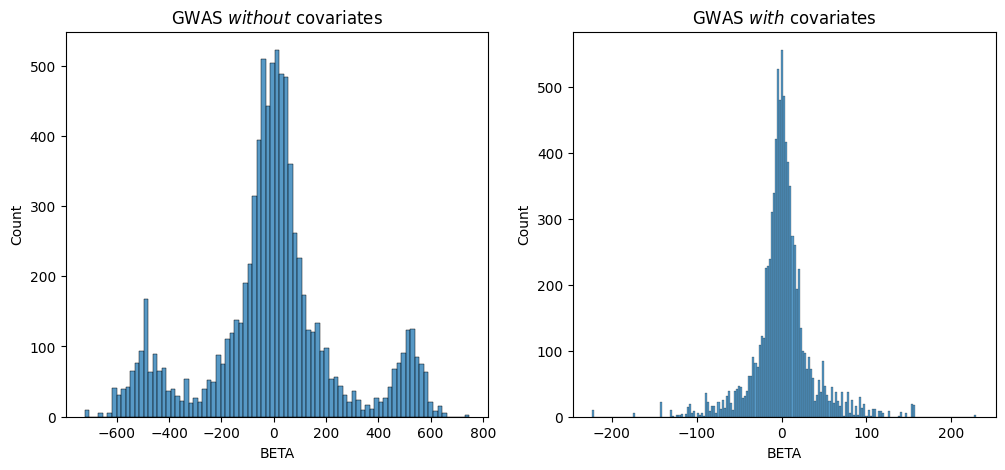

In [9]:
import seaborn
import matplotlib.pyplot as plt

f, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = seaborn.histplot(data=gwas_df, x="BETA", ax=axs[0])
axs[0].set_title("GWAS $\it{without}$ covariates")
seaborn.histplot(data=gwascov_df, x="BETA", ax=axs[1])
axs[1].set_title("GWAS $\it{with}$ covariates")

Since we simulated the genetic effects that "cause" the phenotype we're studying, we know that the underlying BETA distribution is normal and centered at 0. Both of these results show a roughly normal distribution centered at 0, but you can see that the one which corrected for the covariate has a clearer distribution without the "extra" peaks around `-500-.

### Using the Python API

We can just repeat the same thing via Python, as an illustration.

In [10]:
from grapp.assoc import linear_assoc_covar
import pygrgl

GRG_FILE = "gwas.example.grg"
PHEN_FILE = "covar.example.grg.phen"

# Load the GRG into memory
grg = pygrgl.load_immutable_grg(GRG_FILE)

# Load the phenotype into memory
Y = pandas.read_csv(PHEN_FILE, delimiter="\t")

# Perform the GWAS
gwas_df = linear_assoc_covar(grg, Y["phenotypes"].to_numpy(), covar_df.to_numpy())
gwas_df

,POS,ALT,COUNT,BETA,SE,T,P
0,55829,G,4,-51.048086,127.006567,-0.401933,0.688172
1,56812,T,3,-13.716917,152.570359,-0.089906,0.928454
2,57349,G,1,-28.959683,467.645128,-0.061927,0.950684
3,58785,T,10,-35.693720,38.173918,-0.935029,0.350924
4,59367,A,2,17.971173,238.352202,0.075398,0.939975
...,...,...,...,...,...,...,...
10888,9997601,G,3,9.707284,152.495658,0.063656,0.949309
10889,9998038,A,21,10.507445,21.127264,0.497341,0.619506
10890,9998412,G,42,5.477115,28.741514,0.190565,0.849064
10891,9999031,C,295,-0.208170,19.039536,-0.010934,0.991288


We can see that the output format (dataframe) is the same as the command line version. We should expect some differences in the distribution of betas because we standardized $X$ this time, though the shape should still be a normal distribution centered at $0$.

<Axes: xlabel='BETA', ylabel='Count'>

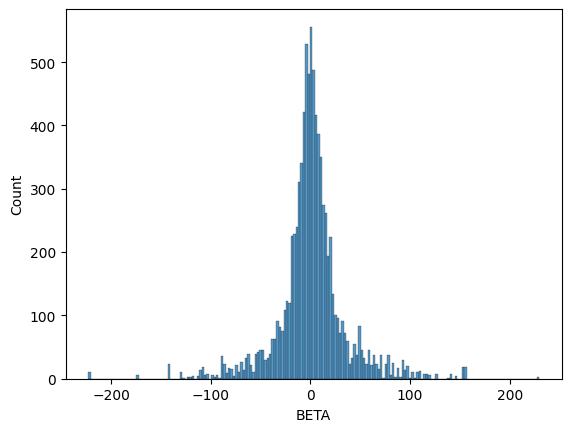

In [11]:
seaborn.histplot(data=gwas_df, x="BETA")

## Related Topics

* See [GWAS](GWAS.html) and [PCA](PCA.html) for for details.
* See [Simulating Phenotypes](SimulatingPhenotypes.html) for a more details on generating synthetic phenotypes.
* Documentation links:
  * [grapp.assoc](https://grapp.readthedocs.io/en/latest/grapp.html#module-grapp.assoc): Python APIs for GWAS on GRG
  * [grg_pheno_sim.phenotype](https://grg-pheno-sim.readthedocs.io/en/latest/grg_pheno_sim.html#module-grg_pheno_sim.phenotype): Python APIs for phenotype simulation on GRG